In [164]:
import numpy as np
import pandas as pd
import seaborn as sns
from pathlib import Path
import os
import yaml
from omegaconf import DictConfig
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

In [143]:
results_dir = Path('experiments')
possible_experiment_settings = ('vanilla', 'memory', 'target', 'memory+target')

In [4]:
!ls

blog_post.md  dqn.py	       experiments  Untitled.ipynb
config.yaml   environment.yml  README.md


In [84]:
config

{'env': 'CartPole-v1', 'batch_size': 32, 'sample_memory': True, 'memory_capacity': 1000000, 'hidden_sizes': [128], 'num_episodes': 200, 'epsilon': 1.0, 'discount_factor': 0.99, 'exploration_steps': 1500, 'optimizer': 'Adam', 'lr': 0.001, 'use_target_net': False, 'update_target_freq': 10000, 'log_freq': 20}

In [85]:
def get_experiment_setting(config):
    result = 'vanilla'
    if config.sample_memory and config.use_target_net:
        result = 'memory+target'
    elif config.sample_memory:
        result = 'memory'
    elif config.use_target_net:
        result = 'target'
    return result

In [98]:
def load_experiment_results():
    """
    Extract info from all experiments.
    
    Returns a dictionary: result[environment][experiment_setting][config][seed] -> dataframe for 1 run
    """
    result = {}

    for experiment_dir in list(results_dir.glob('*')):
        # skip yaml and other bs files
        if not experiment_dir.is_dir():
            continue

        hydra_dir = experiment_dir / '.hydra'
        config_file = hydra_dir / 'config.yaml'

        with open(config_file) as f:
            config = dict(yaml.safe_load(f))
        seed = config.pop('seed')
        config = DictConfig(config)

        environment = config.env
        experiment_setting = get_experiment_setting(config)
        
        if environment not in result:
            result[environment] = {}
        if experiment_setting not in result[environment]:
            result[environment][experiment_setting] = {}
        if config not in result[environment][experiment_setting]:
            result[environment][experiment_setting][config] = {}
        # if same experiment and same seed, only use one of them and skip the rest
        if seed not in result[environment][experiment_setting][config]:
            df = pd.read_csv(experiment_dir / 'exp_records.csv', index_col=0)
            result[environment][experiment_setting][config][seed] = df
    return result

In [101]:
# %debug
results = load_experiment_results()

In [216]:
def get_max_q_values(results):
    """
    Extract max q values from experiment results, which is output from `load_experiment_results`.
    
    Returns a dictionary: result[environment][experimential_setting] -> np array max q value for each run
    """
    max_q_values = {}
    for environment, environment_results in results.items():
        if environment not in max_q_values:
            max_q_values[environment] = {}
        for experimental_setting, setting_results in environment_results.items():
            max_q_values[environment][experimental_setting] = []
            for config, seeds_results in setting_results.items():
                for seed, actual_results in seeds_results.items():
                    max_q_value = actual_results.loc[actual_results.index[-1], 'max_q_values']
                    max_q_values[environment][experimental_setting].append(max_q_value)
            max_q_values[environment][experimental_setting] = np.array(max_q_values[environment][experimental_setting])
            
    return max_q_values

In [217]:
max_q_values = get_max_q_values(results)

In [250]:
def make_violinplots(q_vals, environment=None, figsize=(15,10), save_path=None):
    """
    Make violinplots similar to van Hassalt et al.
    
    q_vals input from 'get_max_q_values' function.
    
    If environment is not specified, merge all environments together for the plot.
    """
    max_q_dfs = {}
    for env, vals in max_q_values.items():
         max_q_dfs[env] = pd.DataFrame(vals)

    if environment is not None:
        df = max_q_dfs[environment]
    else:
        # merges all environments together
        df = pd.concat([df for df in max_q_dfs.values()])

    df_melt = pd.melt(df)

    fig, ax = plt.subplots(figsize=figsize)
    sns.violinplot(data=df_melt, x='variable', y='value', order=possible_experiment_settings, scale='count',
                   cut=0, inner='stick', ax=ax)
    ax.axhline(100, linestyle='--', color='black', linewidth=3)
    ax.set_xlabel(None)
    ax.set_ylabel('max abs Q', fontsize=20)
    ax.set_yscale('log')
    ax.yaxis.set_major_formatter(mticker.ScalarFormatter())
    ax.grid(axis='y')
    ax.tick_params(axis='x', labelsize=15)
    if save_path is not None:
        plt.savefig(save_path)

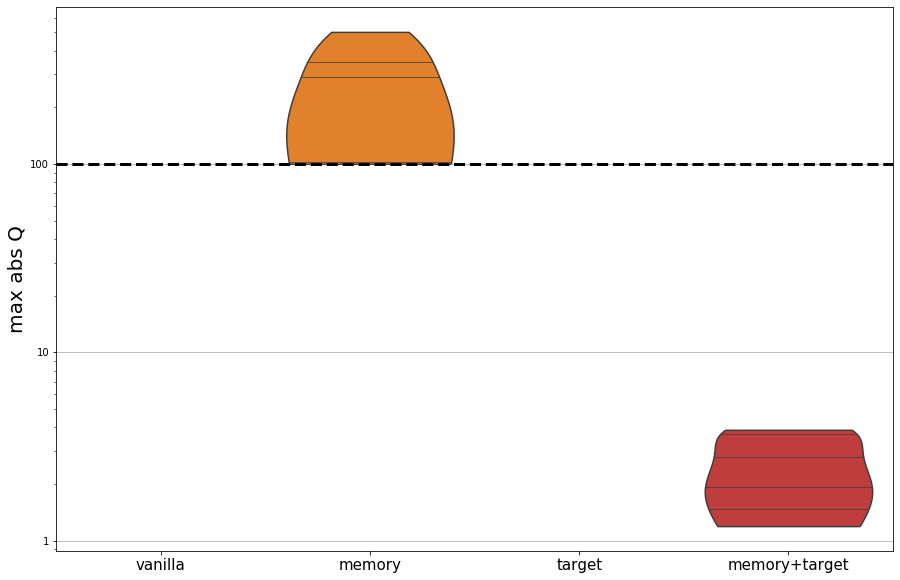

In [251]:
make_violinplots(max_q_values)